In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import socket
print(socket.gethostname())
import os
os.chdir("/home/icb/alioguz.can/projects/campa_pt")

/home/icb/alioguz.can/miniconda3/envs/campa_pt/bin/python
gpusrv58.scidom.de


# Cluster data into CSLs

Using the trained `condVAE_pert-CC` model, this tutorial looks at how to cluster the learned latent representation into CSLs.
In order to ensure that the clusters and their annotations are reproducible, we will use a pretrained model in this example. You can also use the model that you trained in the [Train and evaluate models tutorial](train.ipynb), but due to the randomness of training neural networks, the latent space might be different, resulting in different clusters.

In this tutorial we will:

- create and cluster a smaller subset of the large dataset
- interactively cluster the data
- query the Human Protein Atlas to get candidate annotations
- annotate the data and plot the results on example cells 
- prepare the entire dataset for clustering
- project the clustering to the entire dataset

In [2]:
from pathlib import Path
import os

from IPython.display import display
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from campa.pl import annotate_img
from campa.tl import (
    Cluster,
    TorchExperiment,
    create_cluster_data,
    get_clustered_cells,
    load_full_data_dict,
    prepare_full_dataset,
    project_cluster_data,
    add_clustering_to_adata,
)
from campa.data import MPPData, load_example_data, load_example_experiment
from campa.utils import init_logging
from campa.constants import campa_config

# init logging with level INFO=20, WARNING=30
init_logging(level=30)
# ensure that example data is downloaded
load_example_data()
# read correct campa_config -- created with setup.ipynb
CAMPA_DIR = Path.cwd()
campa_config.config_fname = CAMPA_DIR / "notebooks/params/campa.ini"
print(campa_config)

/home/icb/alioguz.can/miniconda3/envs/campa_pt/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Reading config from /ictstr01/home/icb/alioguz.can/projects/campa_pt/notebooks/params/campa.ini
CAMPAConfig (fname: /ictstr01/home/icb/alioguz.can/projects/campa_pt/notebooks/params/campa.ini)
EXPERIMENT_DIR: /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments
BASE_DATA_DIR: /home/icb/alioguz.can/projects/campa_pt/notebooks/example_data
CO_OCC_CHUNK_SIZE: 10000000.0
data_config/exampledata: /home/icb/alioguz.can/projects/campa_pt/notebooks/params/ExampleData_constants.py



First, we need to download the pretrained model

In [5]:
# example_experiment_folder = load_example_experiment(campa_config.EXPERIMENT_DIR)
# print("Example experiment downloaded to:", example_experiment_folder)

Example experiment downloaded to: /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained


## Prepare a subset of the data
First, the the data is subsampled, because we would like the clustering to be interactive and feasible to compute on a laptop. 
If you have more time or access to GPUs, you could also consider to skip the subsampling step and cluster all data directly.

Sub-setting and clustering the data can be done with the high-level API, using [create_cluster_data][].
Alternatively, the CLI can be used:
```
cd CAMPA_DIR/params
campa cluster test/CondVAE_pert-CC create --subsample --frac 0.1 --save-dir aggregated/sub-0.1 --cluster
```

If you would like to also directly cluster the data, use `cluster=True` in the call to [create_cluster_data][]. Here, we leave the clustering for the interactive clustering and annotation step below.

[create_cluster_data]: ../api/campa.tl.create_cluster_data.rst

In [41]:
create_cluster_data("/home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/torch_test/CondVAE_pert-CC", subsample=True, frac=0.1, save_dir="aggregated/sub-0.1")

Device: cuda
Condition encoder created
Initializing model with weights from /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/torch_test/CondVAE_pert-CC/weights_epoch020


/ictstr01/home/icb/alioguz.can/projects/campa_pt/campa/tl/_evaluate.py:808: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.est.model.encoder(torch.tensor(x)) # because mpp has shape batch_size x neighbors x neighbors x channels


KeyboardInterrupt: 

This has created a subset of 10% of all pixels in `aggregated/sub-0.1`. This again is readable as [MPPData][].
Note that in order to correctly load the MPPData here, we have to define the `data_config`, and set the `base_dir` to the `EXPERIMENT_DIR`, as per default, `MPPData` looks for data relative to `DATA_DIR` defined in `data_config`. 

[MPPData]: ../classes/campa.data.MPPData.rst

In [14]:
cluster_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/sub-0.1"
print(os.listdir(os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir)))
print(MPPData.from_data_dir(cluster_data_dir, data_config="ExampleData", base_dir=campa_config.EXPERIMENT_DIR))

['channels.csv', 'labels.npy', 'latent.npy', 'y.npy', 'conditions.npy', 'umap.npy', 'mpp.npy', 'obj_ids.npy', 'cluster_params.json', 'metadata.csv', 'x.npy']
MPPData for ExampleData (67084 mpps with shape (3, 3, 34) from 46 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp', 'labels', 'latent', 'conditions'].


## Prepare full dataset for projecting cluster to it
To project the clustering to the entire dataset, the model needs to be used to predict the latent representation on all data. 
It is recommended to run this step in a script, as this might take a while for large datasets:
```
cd CAMPA_DIR/params
campa cluster test/CondVAE_pert-CC prepare-full --save-dir aggregated/full_data
```
This script uses the [prepare_full_dataset] function of the high-level API.

[prepare_full_dataset]: ../api/campa.tl.prepare_full_dataset.rst

In [17]:
prepare_full_dataset("test_pre_trained/CondVAE_pert-CC", save_dir="aggregated/full_data")

iterating over data dirs ['184A1_unperturbed/I09', '184A1_unperturbed/I11', '184A1_meayamycin/I12', '184A1_meayamycin/I20']
Device: cuda
Condition encoder created
Initializing model with weights from /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/weights_epoch010


/ictstr01/home/icb/alioguz.can/projects/campa_pt/campa/tl/_evaluate.py:808: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.est.model.encoder(torch.tensor(x)) # because mpp has shape batch_size x neighbors x neighbors x channels


Device: cuda
Condition encoder created
Initializing model with weights from /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/weights_epoch010


/ictstr01/home/icb/alioguz.can/projects/campa_pt/campa/tl/_evaluate.py:808: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.est.model.encoder(torch.tensor(x)) # because mpp has shape batch_size x neighbors x neighbors x channels


Device: cuda
Condition encoder created
Initializing model with weights from /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/weights_epoch010


/ictstr01/home/icb/alioguz.can/projects/campa_pt/campa/tl/_evaluate.py:808: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.est.model.encoder(torch.tensor(x)) # because mpp has shape batch_size x neighbors x neighbors x channels


Device: cuda
Condition encoder created
Initializing model with weights from /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/weights_epoch010


/ictstr01/home/icb/alioguz.can/projects/campa_pt/campa/tl/_evaluate.py:808: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.est.model.encoder(torch.tensor(x)) # because mpp has shape batch_size x neighbors x neighbors x channels


This saves the predicted data to `aggregated/full_data`. As usual, this can be loaded using [MPPData][].

[MPPData]: ../classes/campa.data.MPPData.rst

In [18]:
full_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/full_data"
print(os.listdir(os.path.join(campa_config.EXPERIMENT_DIR, full_data_dir)))
# load MPPData from one data_dir
print(
    MPPData.from_data_dir(
        os.path.join(full_data_dir, "184A1_unperturbed/I09"),
        data_config="ExampleData",
        base_dir=campa_config.EXPERIMENT_DIR,
    )
)

['184A1_unperturbed', '184A1_meayamycin']
MPPData for ExampleData (153669 mpps with shape (1, 1, 35) from 12 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp', 'labels', 'latent'].


## Interactive clustering and annotation
Now we can cluster our data. This is done by getting an `anndata` object from the [Cluster.cluster_mpp][] object using [MPPData.get_adata][] and clustering it using `scanpy`. 

Note that for reproducing the clustering we will use the downloaded subsampled and projected data in `aggregated/sub-pre` for the clustering.

[Cluster]: ../classes/campa.tl.Cluster.rst
[Cluster.cluster_mpp]: ../classes/campa.tl.Cluster.cluster_mpp.rst
[MPPData.get_adata]: ../classes/campa.data.MPPData.get_adata.rst

In [19]:
# load cl
cluster_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre"
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})

`adata` contains pixels as `obs` and protein channels as `var`. The cVAE latent space is stored in `obsm['X_latent']`.

In [20]:
print("obs:", adata.obs.index)
print("var:", adata.var.index)
print("X_latent shape:", adata.obsm["X_latent"].shape)

obs: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '67074', '67075', '67076', '67077', '67078', '67079', '67080', '67081',
       '67082', '67083'],
      dtype='object', length=67084)
var: Index(['01_CDK9_pT186', '01_PABPC1', '02_CDK7', '03_CDK9', '03_RPS6',
       '05_GTF2B', '05_Sm', '07_POLR2A', '07_SETD1A', '08_H3K4me3', '09_CCNT1',
       '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2', '11_KPNA2_MAX', '11_PML',
       '12_RB1_pS807_S811', '12_YAP1', '13_PABPN1', '13_POL2RA_pS5', '14_PCNA',
       '15_SON', '15_U2SNRNPB', '16_H3', '17_HDAC3', '17_SRSF2', '18_NONO',
       '19_KPNA1_MAX', '20_ALYREF', '20_SP100', '21_COIL', '21_NCL', '00_DAPI',
       '07_H2B'],
      dtype='object', name='name')
X_latent shape: (67084, 16)


Cluster the latent space. Here, different clusterings with different resolutions could be created and compared.

In [21]:
# cluster the latent space
sc.pp.neighbors(adata, use_rep="X_latent")
sc.tl.leiden(adata, resolution=0.2, key_added="clustering_res0.2", random_state=0)

/tmp/ipykernel_2559935/2743763027.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.2, key_added="clustering_res0.2", random_state=0)


In [25]:
# write clustering to disk
np.save(
    os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir, "clustering_res0.2"), adata.obs["clustering_res0.2"]
)

### Explore clustered data
The aim of this step is to annotate the clustering, to aid interpretability of the results.
Hereby, CSLs corresponding to the same biological structure may be merged to the same annotated CSL. 
This annotation is done in an iterative fashion and considers the following factors:

- Presence of canonical organelle markers among top enriched channels in each CSL in unperturbed (control) cells. If no canonical markers are present, consider CSL as 'background' (i.e. nucleoplasm / cytoplasm). 
- Spatial distribution of CSLs compared to spatial distribution of canonical markers of organelles in unperturbed (control) cells
- Human Protein Atlas subcellular localisation ([The Human Protein Atlas](https://www.proteinatlas.org), [Thul et al. 2017](https://www.science.org/doi/full/10.1126/science.aal3321)) of top enriched channels in each CSL, weighted by z-scored channel intensity.

Below, we show how to visualise and analyse the clusters for each of these aspects.

Load the `Cluster` object, and export the [Cluster.cluster_mpp][] with [MPPData.get_adata][] and add the just created clustering to the exported adata object with [add_clustering_to_adata][].

[add_clustering_to_adata]: ../api/campa.tl.add_clustering_to_adata.rst
[Cluster.cluster_mpp]: ../classes/campa.tl.Cluster.cluster_mpp.rst
[MPPData.get_adata]: ../classes/campa.data.MPPData.get_adata.rst


In [26]:
# load cl
cluster_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre"
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name("clustering_res0.2")
add_clustering_to_adata(
    os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir), "clustering_res0.2", adata, cl.cluster_annotation
)

Cannot read with memmap:  /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre/clustering_res0.2.npy


The following is a UMAP of the latent space coordinates of each pixel. It is useful to check that the clustering algorithm is doing something sensible, and also that the conditions used in the autoencoder don't end up in different regions of the latent space UMAP (which would indicate that the conditional autoencoder was not able to generate a condition-independent representation). Channel intensities can also be visualised here, which is useful if you have some markers for known structures (e.g. NCL, H3, SON) 

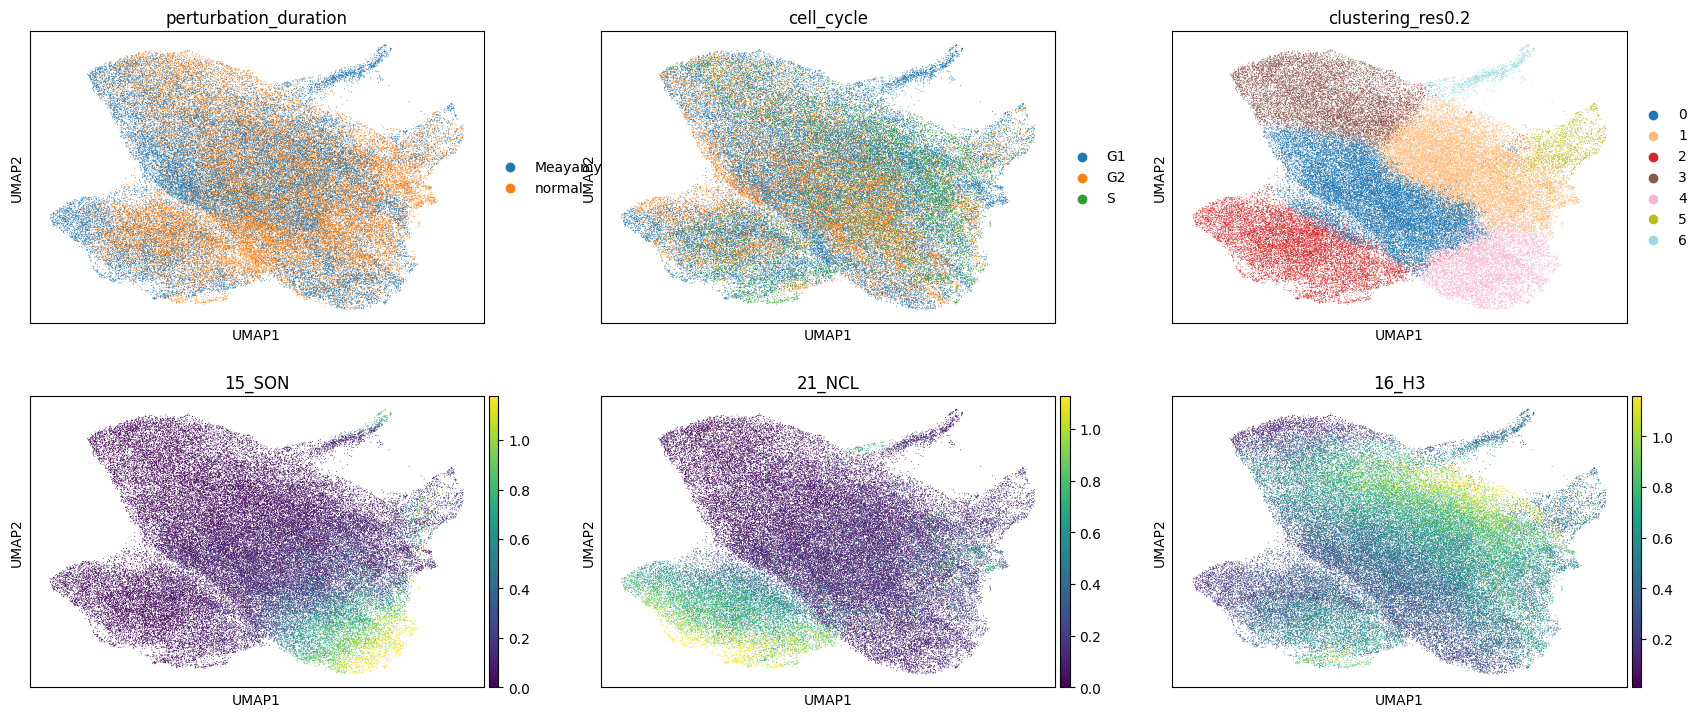

In [27]:
plt.rcParams["figure.figsize"] = [6, 4]
sc.pl.umap(
    adata,
    color=["perturbation_duration", "cell_cycle", "clustering_res0.2", "15_SON", "21_NCL", "16_H3"],
    vmax="p99",
    ncols=3,
)

To begin to understand the identity of each of the clusters, it can be helpful to visualise how the intensity of each of the channels distributes across the clusters:

/tmp/ipykernel_2559935/2829471411.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pixel_values_annotated.groupby(cluster_name).aggregate("mean"),


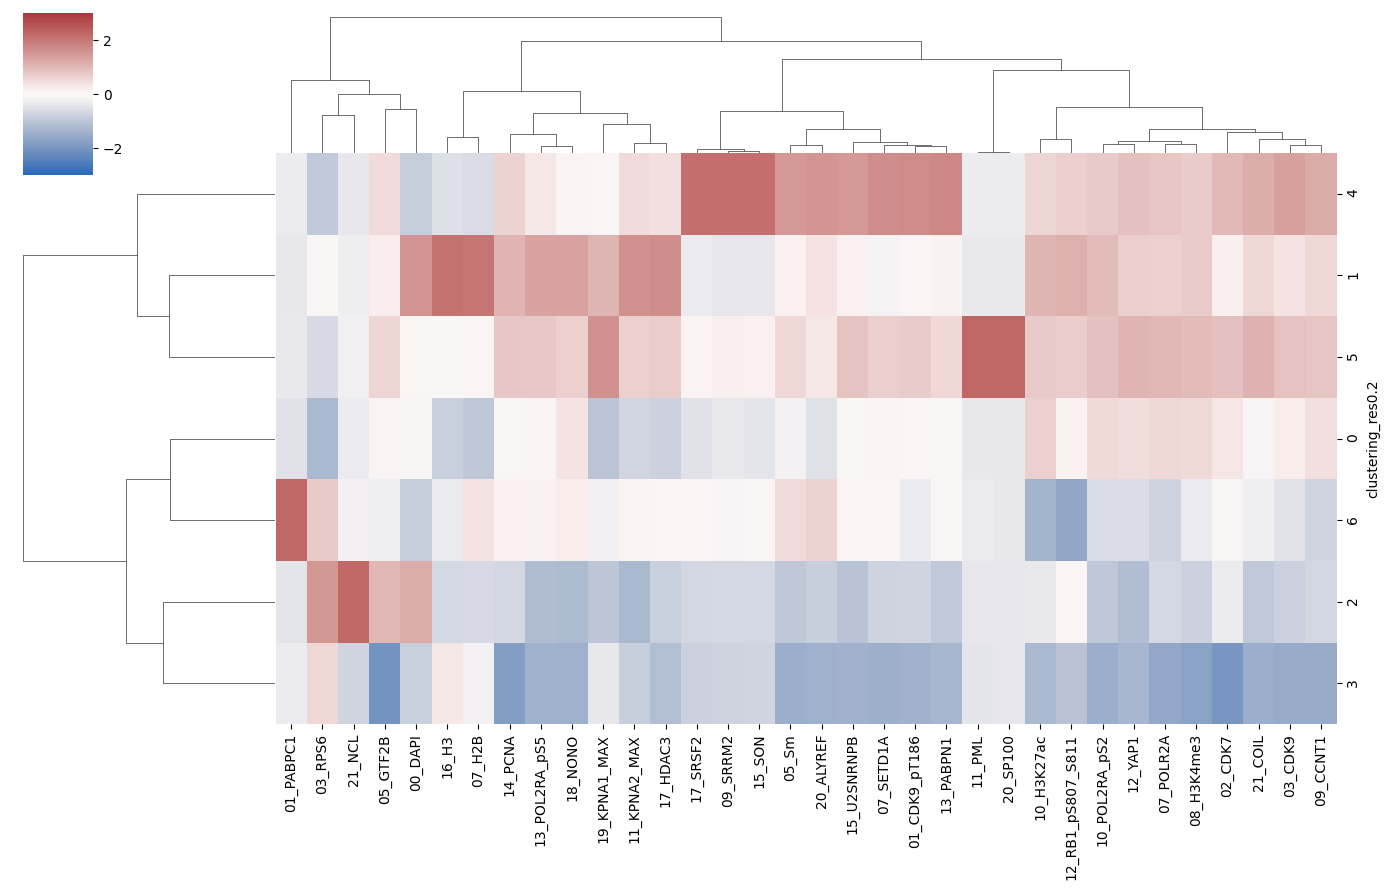

In [28]:
cluster_name = "clustering_res0.2"
pixel_values_annotated = pd.concat(
    [
        pd.DataFrame(adata.X, columns=adata.var_names).reset_index(drop=True),
        adata.obs[[cluster_name]].reset_index(drop=True),
    ],
    axis=1,
)
_ = sns.clustermap(
    pixel_values_annotated.groupby(cluster_name).aggregate("mean"),
    z_score=1,
    cmap="vlag",
    figsize=[14, 9],
    vmin=-3,
    vmax=3,
    method="ward",
)

For example, the plot above reveals that PML-body markers PML and SP100 exclusively localise to cluster 5, which is therefore very likely to correspond to PML bodies.

To identify clusters, it can also be very helpful to plot the clusters directly out over some example cells. Using [load_full_data_dict][] and [get_clustered_cells][], we can cluster some random cells from each well of the experiment.

[load_full_data_dict]: ../api/campa.tl.load_full_data_dict.rst
[get_clustered_cells]: ../api/campa.tl.get_clustered_cells.rst

In [29]:
# NOTE: this may take a couple of minutes
# load data
exp = TorchExperiment.from_dir("test_pre_trained/CondVAE_pert-CC")
mpp_datas = load_full_data_dict(exp)
# project clustering to some example cells
example_cells = {}
example_cells.update(get_clustered_cells(mpp_datas, cl, "clustering_res0.2", num_objs=3))

184A1_unperturbed/I09
184A1_unperturbed/I11
184A1_meayamycin/I12
184A1_meayamycin/I20


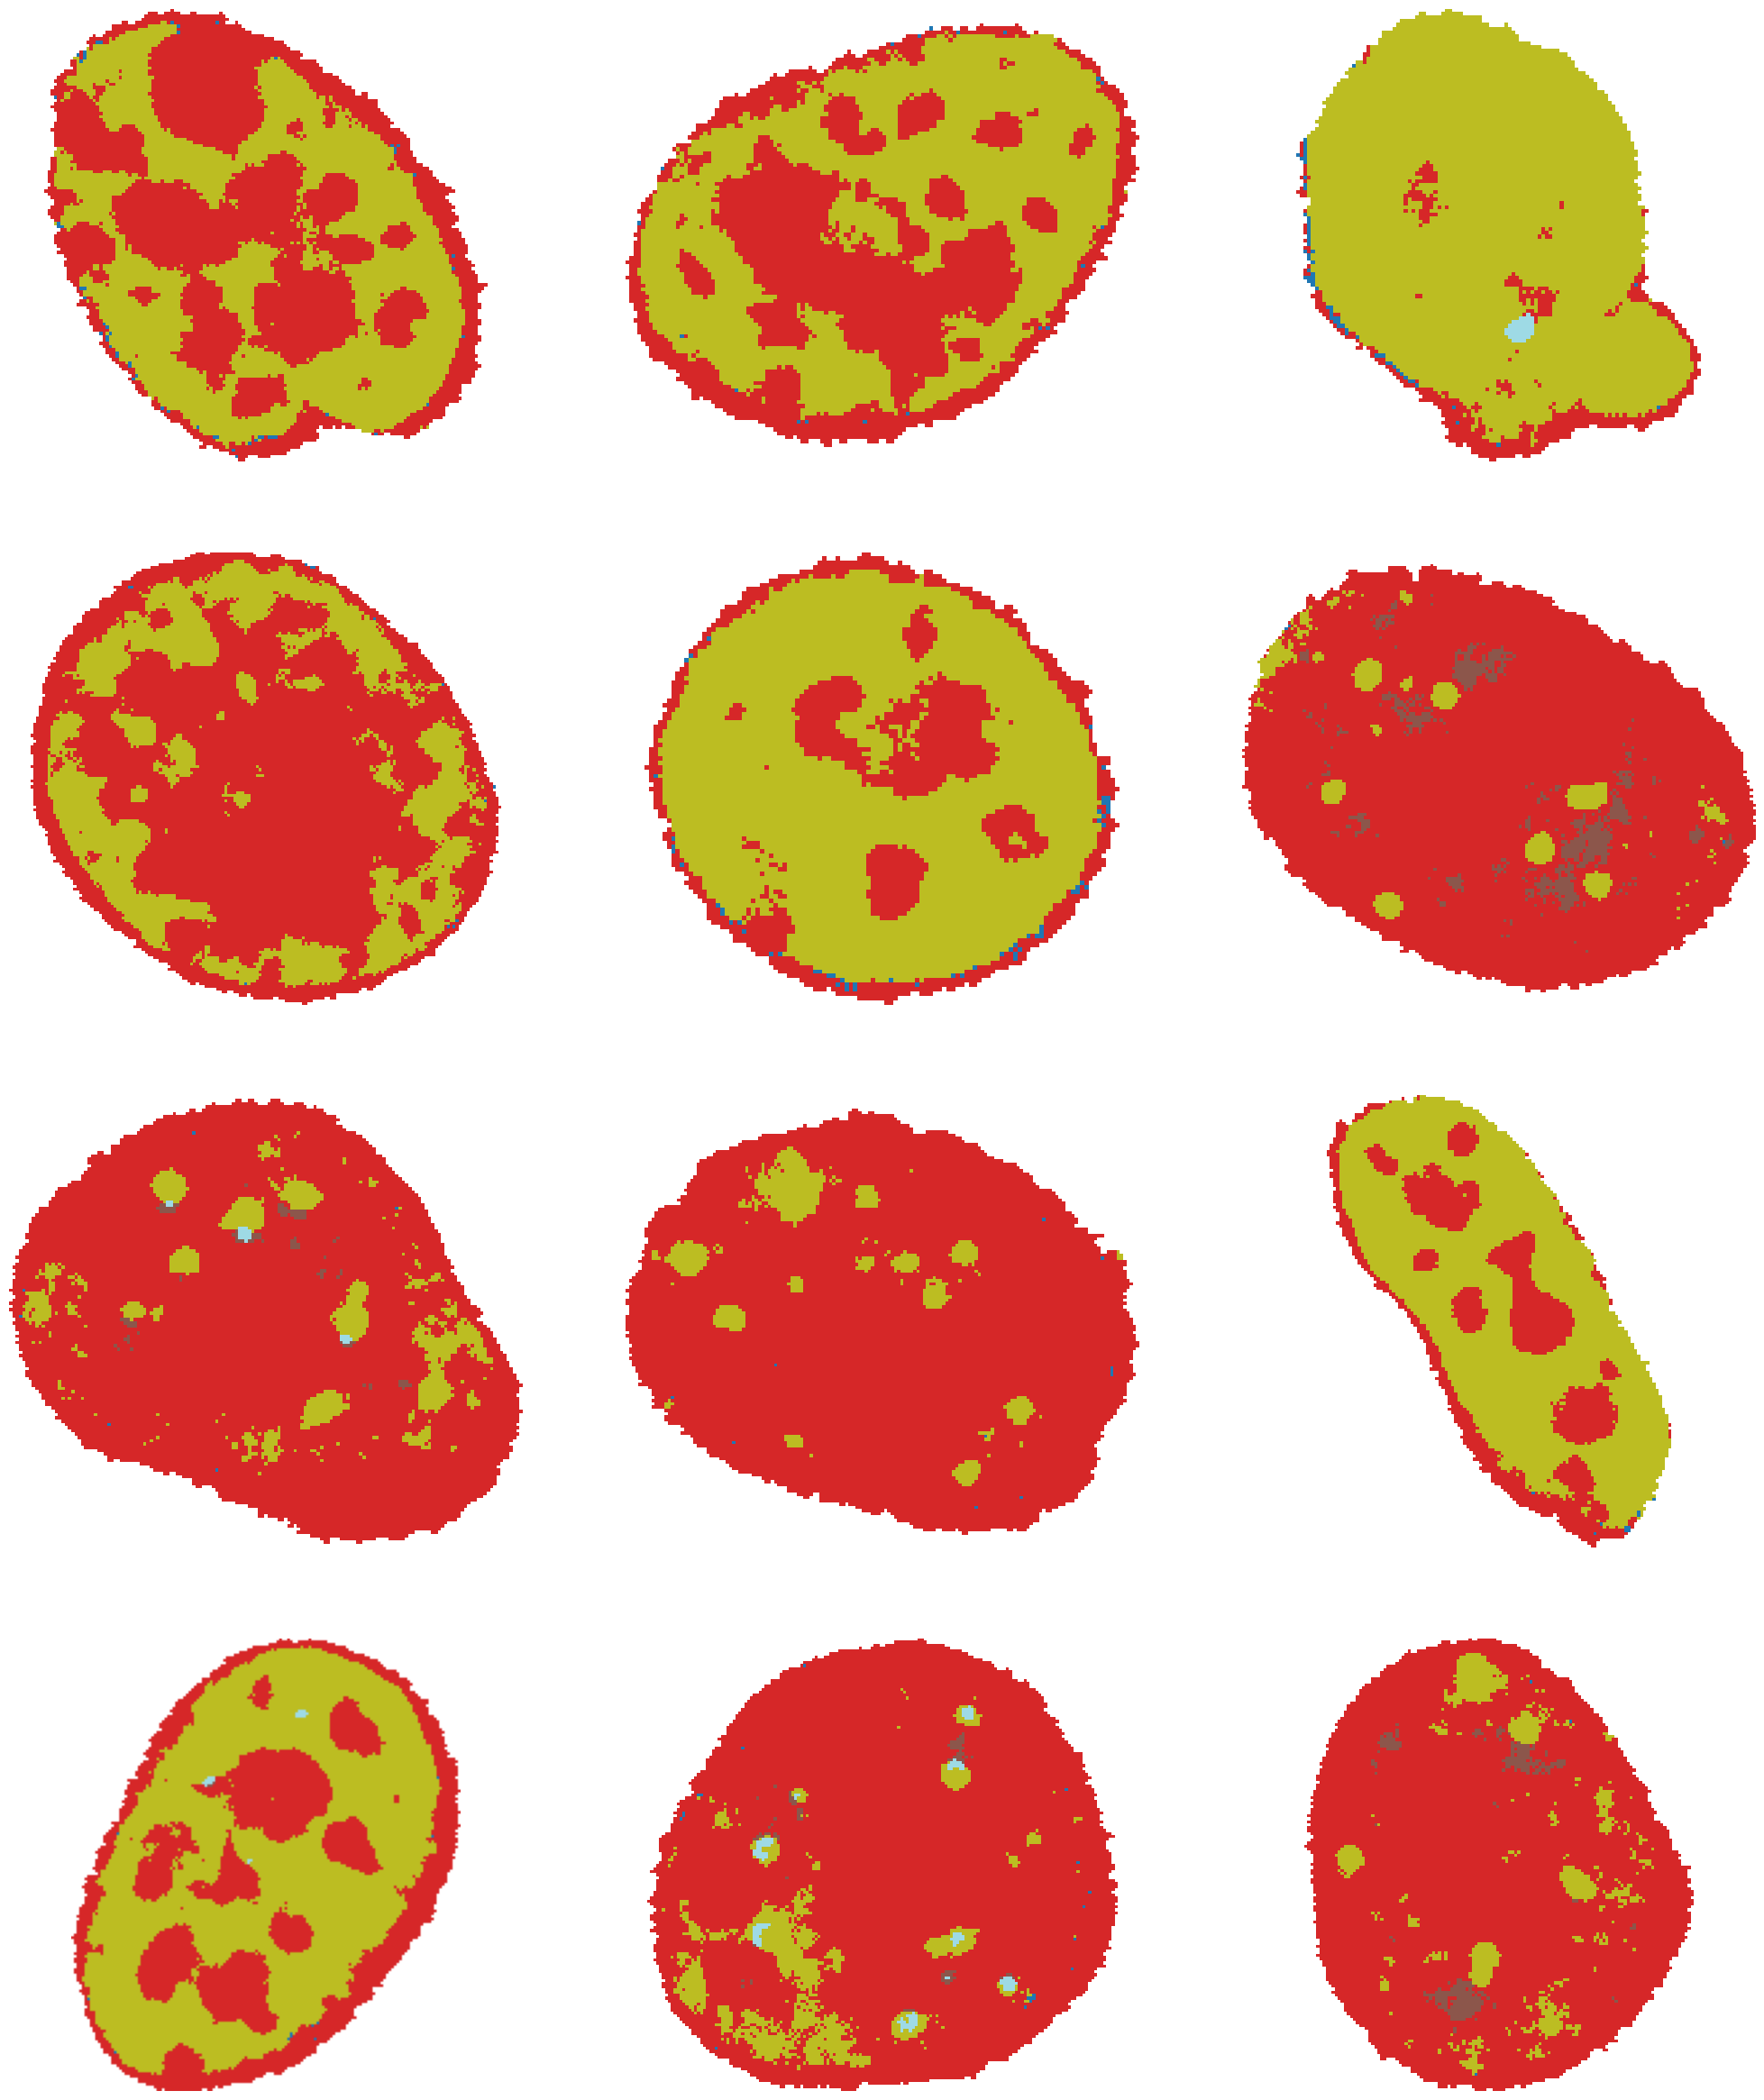

In [30]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
for j, data_dir in enumerate(
    ["184A1_unperturbed/I09", "184A1_unperturbed/I11", "184A1_meayamycin/I12", "184A1_meayamycin/I20"]
):
    for i in range(3):
        axes[j, i].imshow(example_cells["clustering_res0.2_colored"][data_dir][i])

for ax in axes.flat:
    ax.axis("off")

### Get subcellular localisation from HPA

We can also query the Human Protein Atlas to get subcellular locations of the most enriched channels for each protein.
For this, we will use [Cluster.get_hpa_localisation]. This function returns a dictionary of results for each cluster in our data.
Here, we set `max_num_channels` to 3 to get a location information from the top 3 most enriched channels per cluster (weighted by z-scored channel intensity).

[Cluster.get_hpa_localisation]: ../classes/campa.tl.Cluster.get_hpa_localisation.rst

In [31]:
cluster_name = "clustering_res0.2"
results = cl.get_hpa_localisation(
    cluster_name=cluster_name, thresh=1, max_num_channels=3, limit_to_groups={"perturbation_duration": "normal"}
)

/ictstr01/home/icb/alioguz.can/projects/campa_pt/campa/tl/_cluster.py:827: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.concat(


This function returns a dictionary for each cluster containing the genes that were used to query HPA for subcellular location and the query results. 
The results dictionary is empty if no enriched channels were found for this cluster or if HPA returned no results.

In [32]:
# look at results for cluster 1
display(results["1"]["hpa_data"])
print(results["1"]["subcellular_locations"])

,Gene,Gene synonym,Reliability (IF),Subcellular main location,Subcellular additional location,gene_weights
H2B,H2BC21,"[H2B, H2B-GL105, H2B.1, H2B/q, H2BE, H2BFQ, HI...",Approved,[Nucleoplasm],[Cytosol],2.140067
H3,H3C14,"[H3, H3.2, H3/m, H3F2, H3FM, HIST2H3C, MGC9629]",Supported,[Nucleoplasm],"[Acrosome, Principal piece]",2.120367
KPNA2,KPNA2,"[IPOA1, PTAC58, QIP2, RCH1, SRP1alpha]",Supported,[Nucleoplasm],[Cytosol],1.634049


Nucleoplasm    5.894483
dtype: float64


Text(0.5, 0.98, 'Subcellular locations by HPA for clustering clustering_res0.2')

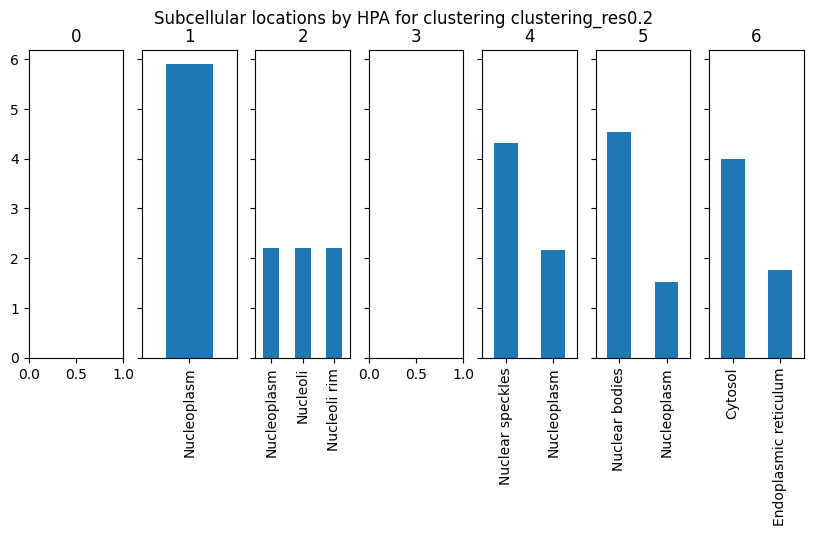

In [33]:
# plot HPA annotation of clusters
fig, axes = plt.subplots(1, len(results), squeeze=False, sharey=True, figsize=(10, 4))
for ax, (idx, res) in zip(axes.flat, results.items()):
    if res["subcellular_locations"] is not None:
        res["subcellular_locations"].plot(kind="bar", ax=ax)
    ax.set_title(idx)
plt.suptitle(f"Subcellular locations by HPA for clustering {cluster_name}")

### Annotate clustering
Now, we are ready to annotate the clustering with names of the known structures. 
We will use the HPA subcellular locations, the example images showing the spatial distribution of clusters in cells, and the channel intensities in each cluster plotted above to make a final assignment of clusters to names. 
Note that this annotation might vary slightly when rerunning this experiment and clustering, due to the inherent randomness of neural network training. 
As misannotations can introduce a bias in subsequent analysis of the CSLs, we recommend that users only annotate those CSLs where they are sure that this CSL corresponds to the annotated structure.

In this example, we map multiple different clusters to "Nucleoplasm" because we are not especially interested in these different Nucleoplasm 'flavours' identified, which tend to occur heterogeneously between cells. This merging process is entirely optional and we recommend that users keep these separate unless they are sure they want to merge. Another possibility is 'Nucleoplasm 1', 'Nucleoplasm 2' etc. 

For the annotation, we will create a dictionary mapping leiden cluster names to annotated names, and use [Cluster.add_cluster_annotation][] to add the annotation to the [Cluster][] object. Annotations and colour maps for the annotations are stored in a csv file in the `cluster_data_dir`.

[Cluster.add_cluster_annotation]: ../classes/campa.tl.Cluster.add_cluster_annotation.rst
[Cluster]: ../classes/campa.tl.Cluster.rst

In [34]:
annotation = {
    # No enriched markers -> nucleoplasm
    "0": "Nucleoplasm",
    # Nucleoplasm (consistent with HPA label)
    "1": "Nucleoplasm",
    # Nucleolus, due to appearance of NCL marker in this cluster.
    # HPA assigns either Nucleoplasm, Nucleoli or Nucleoli rim label
    "2": "Nucleolus",
    # No enriched markers -> nucleoplasm
    "3": "Nucleoplasm",
    # HPA label: Nuclear speckles
    "4": "Nuclear speckles",
    # HPA label: nuclear bodies (= PML bodies).
    "5": "PML bodies",
    # HPA label: cytosol
    # This is a PABPC-1 enriched cluster only occurring on the Meayamycin perturbation (see UMAP)
    # This occurs here, because we did not use enough training data to train a completely perturbation-independent embedding of the data.
    # Let us assign this small cluster of Nucleoplasm for now.
    # Note that in the manuscript, we don't have perturbation-specific clusters in the cVAE output.
    "6": "Nucleoplasm",
}

cl.set_cluster_name("clustering_res0.2")
cl.add_cluster_annotation(annotation, "annotation")

The resulting cluster annotation data frame is stored in `cluster_data_dir/clustering_res0.2_annotation.csv`

In [35]:
# check out the resulting cluster annotation data frame - this is stored in cluster_data_dir/clustering_res0.2_annotation.csv
display(cl.cluster_annotation)
cluster_dir = os.path.join(campa_config.EXPERIMENT_DIR, cl.config["cluster_data_dir"])
print(cluster_dir)
print(os.listdir(cluster_dir))

,clustering_res0.2,clustering_res0.2_colors,annotation,annotation_colors
index,,,,
0,0,#1f77b4,Nucleoplasm,#f7b6d2
1,1,#ffbb78,Nucleoplasm,#f7b6d2
2,2,#d62728,Nucleolus,#d62728
3,3,#8c564b,Nucleoplasm,#f7b6d2
4,4,#f7b6d2,Nuclear speckles,#1f77b4
5,5,#bcbd22,PML bodies,#9edae5
6,6,#9edae5,Nucleoplasm,#f7b6d2
7,,#ffffff,NaN,#ffffff


/home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre
['channels.csv', 'labels.npy', 'latent.npy', 'y.npy', 'conditions.npy', 'umap.npy', 'mpp.npy', 'pynndescent_index.pickle', 'obj_ids.npy', 'cluster_params.json', 'clustering_res0.2_annotation.csv', 'clustering_res0.2.npy', 'metadata.csv', 'x.npy']


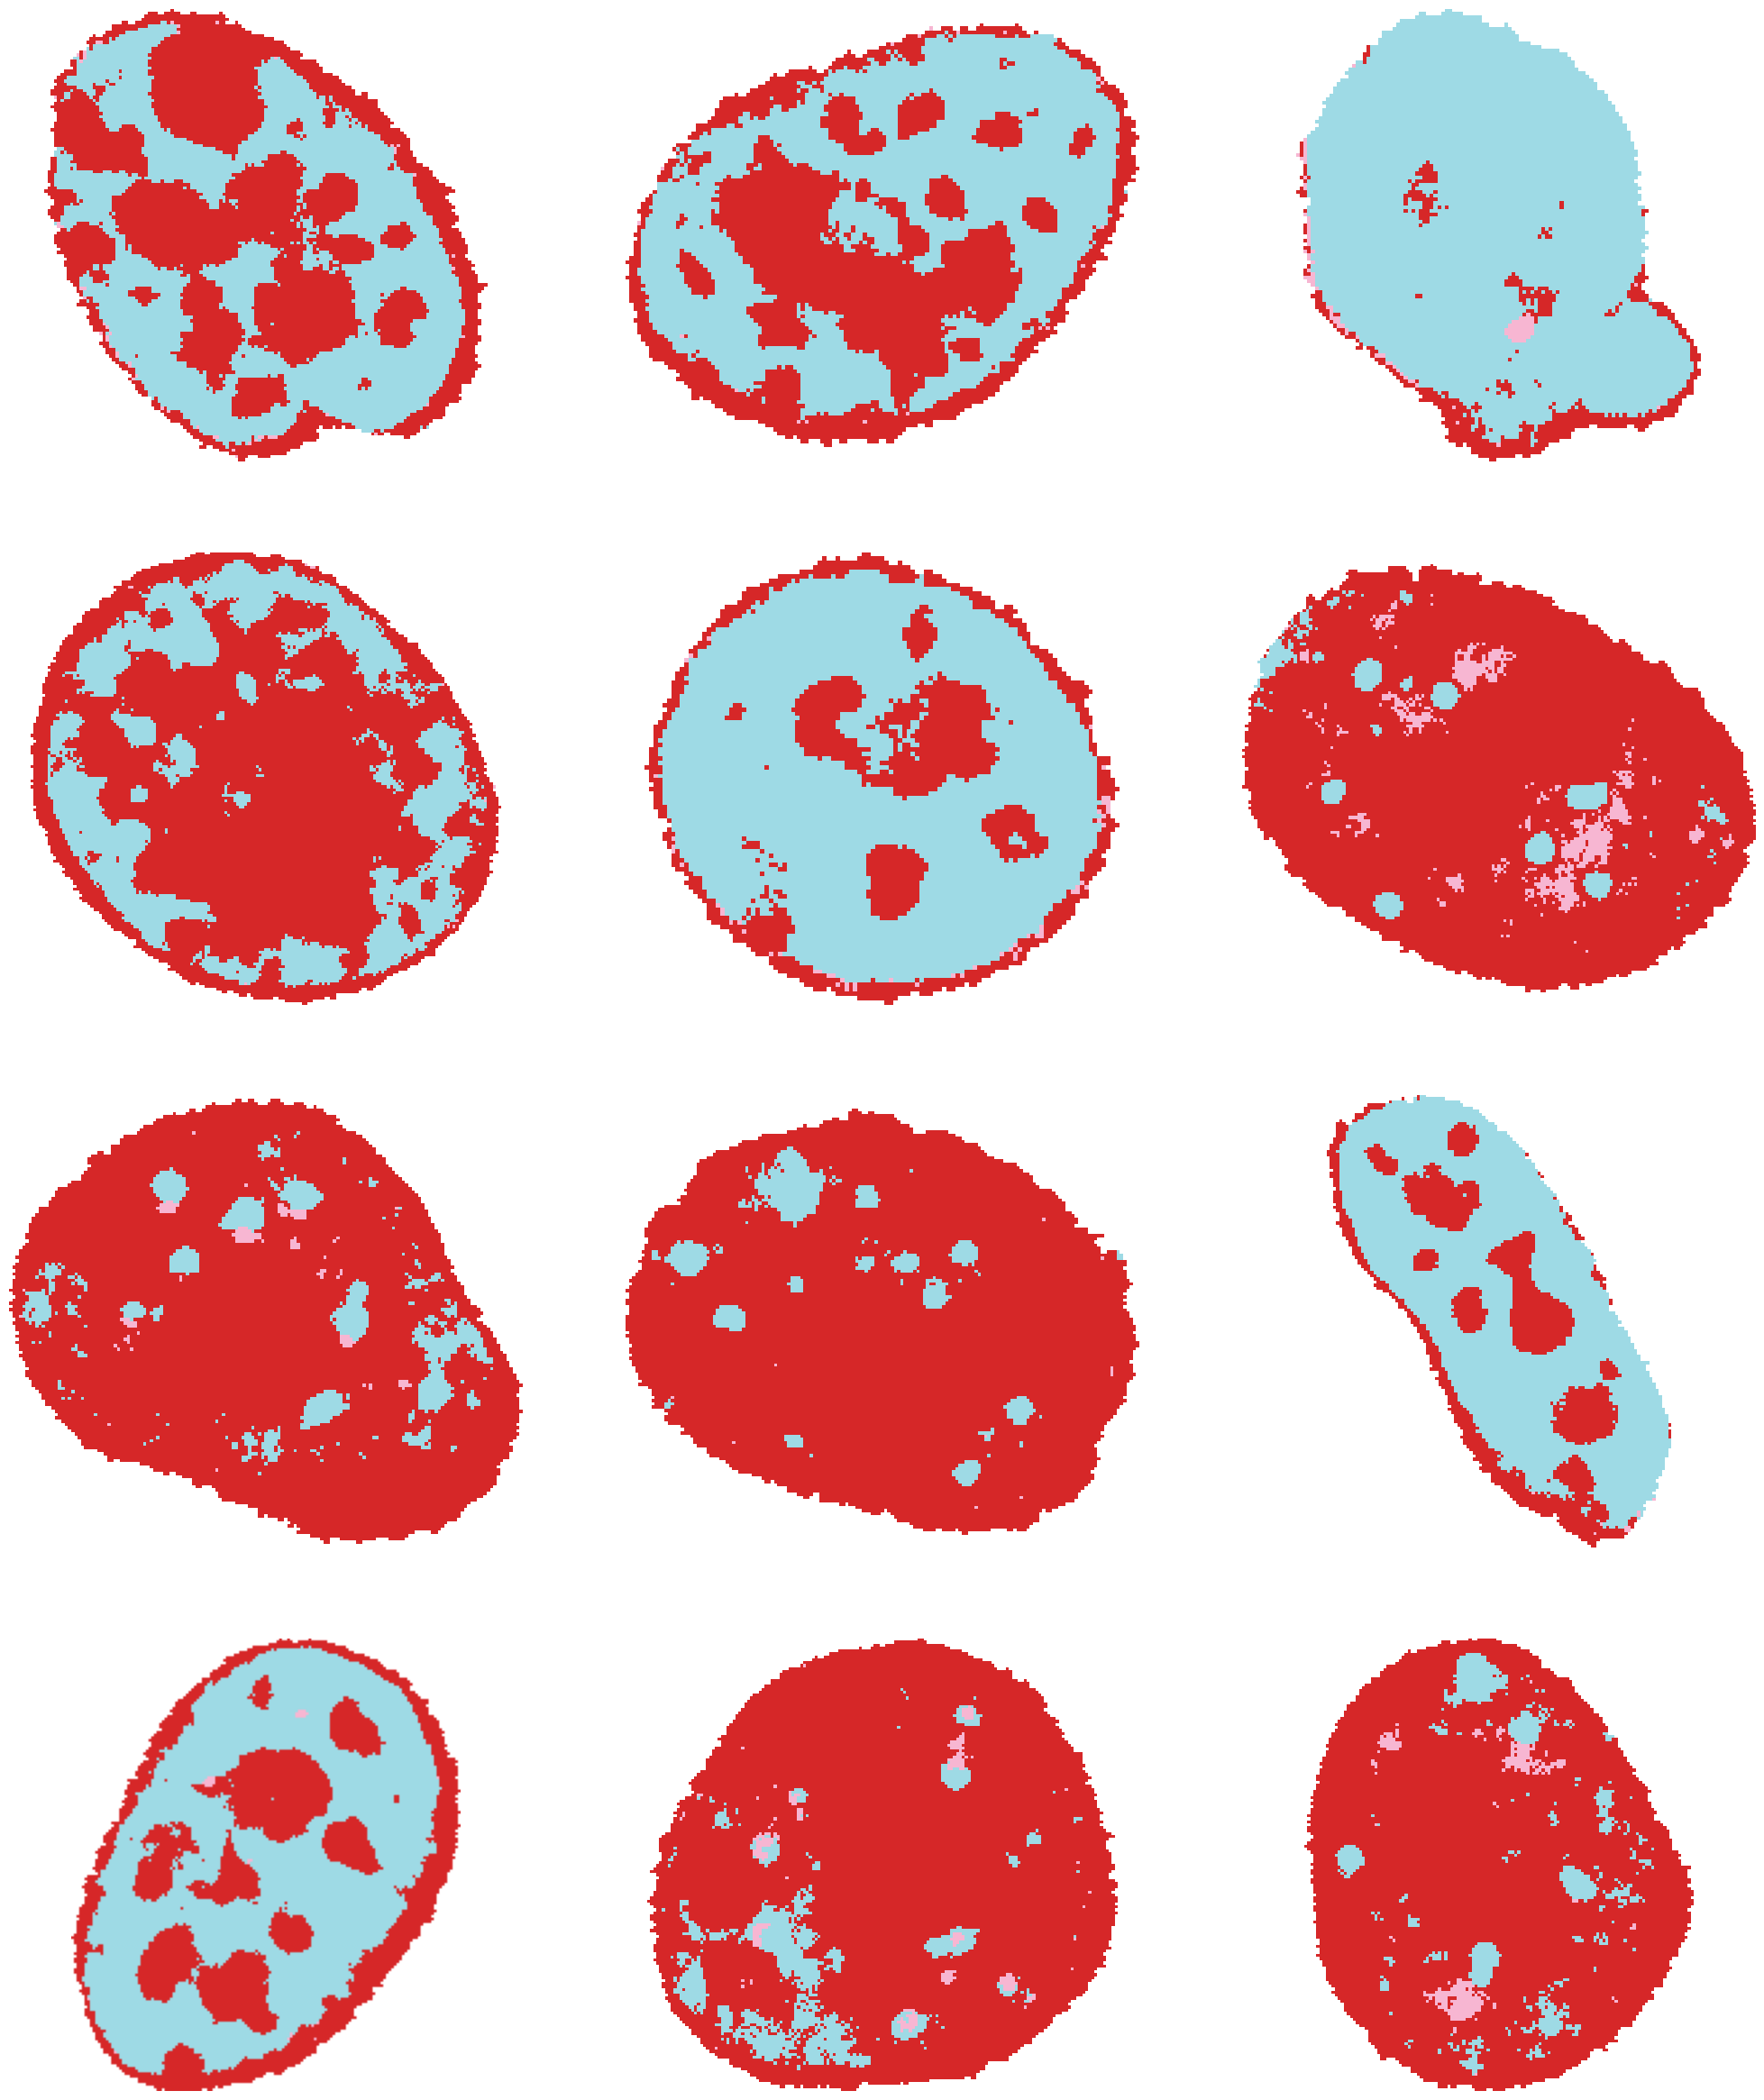

In [36]:
# check out cell colored by new annotation
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
for j, data_dir in enumerate(
    ["184A1_unperturbed/I09", "184A1_unperturbed/I11", "184A1_meayamycin/I12", "184A1_meayamycin/I20"]
):
    for i in range(3):
        axes[j, i].imshow(
            annotate_img(
                example_cells["clustering_res0.2"][data_dir][i],
                annotation=cl.cluster_annotation,
                from_col=cl.config["cluster_name"],
                to_col="annotation",
                color=True,
            )
        )

for ax in axes.flat:
    ax.axis("off")

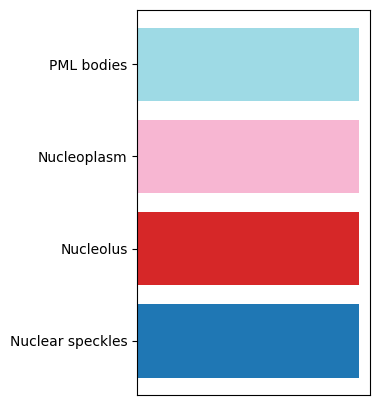

In [37]:
# legend
plt.rcParams["figure.figsize"] = [3, 5]
df = cl.cluster_annotation.groupby("annotation")["annotation_colors"].first()
plt.barh(y=range(len(df)), width=1, color=df)
_ = plt.yticks(range(len(df)), df.index, rotation=0)
_ = plt.xticks([])

## Predict model on full data
After generating a clustering on a subset of the data, we can now project it to the entire dataset. For this, the high-level API function [project_cluster_data][] can be used. Alternatively, the CLI can be used:
```
cd CAMPA_DIR/params
campa cluster test/CondVAE_pert-CC project aggregated/sub-pre --save-dir aggregated/full_data --cluster-name clustering_res0.2
```

[project_cluster_data]: ../api/campa.tl.project_cluster_data.rst

In [39]:
project_cluster_data(
    "test_pre_trained/CondVAE_pert-CC",
    cluster_data_dir="aggregated/sub-pre",
    cluster_name="clustering_res0.2",
    save_dir="aggregated/full_data",
)

Cannot read with memmap:  /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre/clustering_res0.2.npy


MPPData for ExampleData (153669 mpps with shape (1, 1, 35) from 12 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp', 'latent', 'clustering_res0.2'].


MPPData for ExampleData (175632 mpps with shape (1, 1, 35) from 14 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp', 'latent', 'clustering_res0.2'].


MPPData for ExampleData (180723 mpps with shape (1, 1, 35) from 11 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp', 'latent', 'clustering_res0.2'].


MPPData for ExampleData (160820 mpps with shape (1, 1, 35) from 9 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp', 'latent', 'clustering_res0.2'].


This creates `npy` files containing the clustering for the full data:

In [40]:
# check out the resulting clustering using one data_dir
full_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/full_data"
mpp_data = MPPData.from_data_dir(
    os.path.join(campa_config.EXPERIMENT_DIR, full_data_dir, "184A1_unperturbed/I09"),
    data_config="ExampleData",
    keys=["clustering_res0.2"],
)
print("clustering:", mpp_data.data("clustering_res0.2"))

Cannot read with memmap:  /home/icb/alioguz.can/projects/campa_pt/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_unperturbed/I09/clustering_res0.2.npy
clustering: ['5' '2' '2' ... '2' '2' '2']


We are now ready to extract molecular, morphological, and size features from the CSLs. This is described in the [Extract features from CSLs tutorial](extract_features.ipynb).